<a href="https://colab.research.google.com/github/james-hughes1/wdss-nlp-project/blob/main/Exploratory_Analysis_COP25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preamble

In [1]:
# Import libraries
# Data Processing
import pandas as pd
import numpy as np
import re
import datetime as dt
import random

# Statistical Modelling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Files
import os
import zipfile

In [2]:
# Function to make colormap of scatter plots uniform

def scatter_cmap(colours):
    colours_unique = list(set(colours))
    colours_unique.sort()
    n = len(colours_unique)
    colours_scaled = []
    for c in colours:
        colours_scaled.append(colours_unique.index(c)/n)
    return colours_unique, colours_scaled


In [3]:
# Download the GloVe embedding data
# This may take upto 3 minutes

!wget --no-check-certificate \
     http://nlp.stanford.edu/data/glove.6B.zip \
     -O /tmp/glove.6B.zip

--2023-01-30 12:28:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-30 12:28:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-30 12:28:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


In [4]:
# Read and format the twitter scrape .csv file
# Add the .csv file to the workspace or this won't work

dateparse = lambda dates: [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in dates]

tweets_df = pd.read_csv("Twitter Scrape 3_Reduced.csv", usecols=['ID', 'Date', 'Likes', 'Replies', 'Retweets', 'User ID', 'Username', 
                                                                 'Followers', 'Verified', 'Content', 'Time', 'Category'],
                        date_parser = dateparse, parse_dates=["Date"], encoding="UTF-8")
tweets_df["Time"] = pd.to_datetime(tweets_df["Time"], format='%H:%M:%S').dt.time
tweets_df["Date"] = pd.to_datetime(tweets_df["Date"], format='%H:%M:%S').dt.date

In [6]:
# Dendogram plotting function

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(18,16))
    plt.title("Hierarchical Clustering Dendrogram")
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()

In [7]:
# Extract GloVe embedding data

with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


## Text Pre-Processing

In [8]:
# Use regex to clean tweets
tweets_clean = []

for i in range(len(tweets_df)):
    tweet_raw = tweets_df["Content"][i]
    tweet_edit_1 = re.sub("http\S+", "", tweet_raw.lower())
    tweet_edit_2 = re.sub("&amp;", "and", tweet_edit_1)
    tweet_edit_3 = re.sub(r"[^@#%$£\w\⁠s,. ]", "", tweet_edit_2) # Filter emojis
    tweet_edit_4 = re.sub("[.,:;'\"] | [.,:;'\"]", " ", tweet_edit_3)
    tweets_clean.append(tweet_edit_4.strip())

In [9]:
# Sample cleaned tweets

tweets_clean[0]

'for my birthday i want african countries to declare climate emergency and take climate action immediatelyi wish to attend cop25 and talk about the forests in africa especially the congo rainforesti want this message to reach the entire world please rt@gretathunberg'

In [10]:
# Preprocessing hyperparameters

vocab_size = 20000
max_length = 24

# Tokenize text data

tokenizer = Tokenizer(oov_token="<OOV>",
                    num_words=vocab_size,
                    filters="")
tokenizer.fit_on_texts(tweets_clean)

In [11]:
# Construct word frequency dataframe

freq_analysis_df = pd.DataFrame(data = dict(tokenizer.word_counts).items(),
                                columns = ["Word", "Count"]).sort_values(by="Count",ascending=False)

In [12]:
# Build embedding_matrix

word_index = list(freq_analysis_df["Word"])
embedding_matrix = np.zeros((len(word_index), 100))
for i, word in enumerate(word_index):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### Stop Words

In [13]:
nltk.download("stopwords")
stop_words = list(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
print("Fraction stop words: ", np.sum(freq_analysis_df[freq_analysis_df["Word"].isin(stop_words)]["Count"])/np.sum(freq_analysis_df["Count"]))

Fraction stop words:  0.3807291533973657


In [15]:
freq_analysis_df[freq_analysis_df["Count"]==1]

,Word,Count
7497,legacy,1
7526,@akimcampbell,1
9450,spoilers,1
9436,seriousness,1
7587,@wordswithsteph,1
...,...,...
5172,widespread,1
5171,fsv,1
5169,8th,1
5164,#fridaythoughts,1


## Lexicon-Level Analysis

In [16]:
# Word Frequencies

freq_analysis_df.head(50)

,Word,Count
20,the,3959
7,to,2510
51,#cop25,2208
11,and,2054
75,of,1612
22,in,1380
59,at,1142
126,a,1062
0,for,1030
54,is,1012


###Clustering

In [17]:
# Construct non-zero embedding matrix and assign cluster zero

freq_analysis_df["Cluster"] = -1
embeddings = []
valid_word_index = []
for i, row in enumerate(embedding_matrix):
    if (row==0).all():
        freq_analysis_df.iloc[i,2] = 0
    else:
        valid_word_index.append(i)
        embeddings.append(row)
embedding_matrix_nz = np.array(embeddings)

In [18]:
# Number of words not included in GloVe model

count1 = 0
count2 = 0
for row in freq_analysis_df[freq_analysis_df["Cluster"]==0]["Word"]:
  if "#" in row:
    count1+=1
  if "@" in row:
    count2+=1
print("Number of words unknown to GloVe: ", len(freq_analysis_df[freq_analysis_df["Cluster"]==0]))
print("Number of unique hashtags: ", count1)
print("Number of unique user @'s: ", count2)

Number of words unknown to GloVe:  3347
Number of unique hashtags:  1068
Number of unique user @'s:  912


In [19]:
# Agglomerative Clustering (to produce dendrogram, not for actual cluster assignments)

num_clusters_words = 50
clustering_agg_words = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1,
                                               affinity="cosine", linkage="average").fit(normalize(embedding_matrix_nz, axis=1))

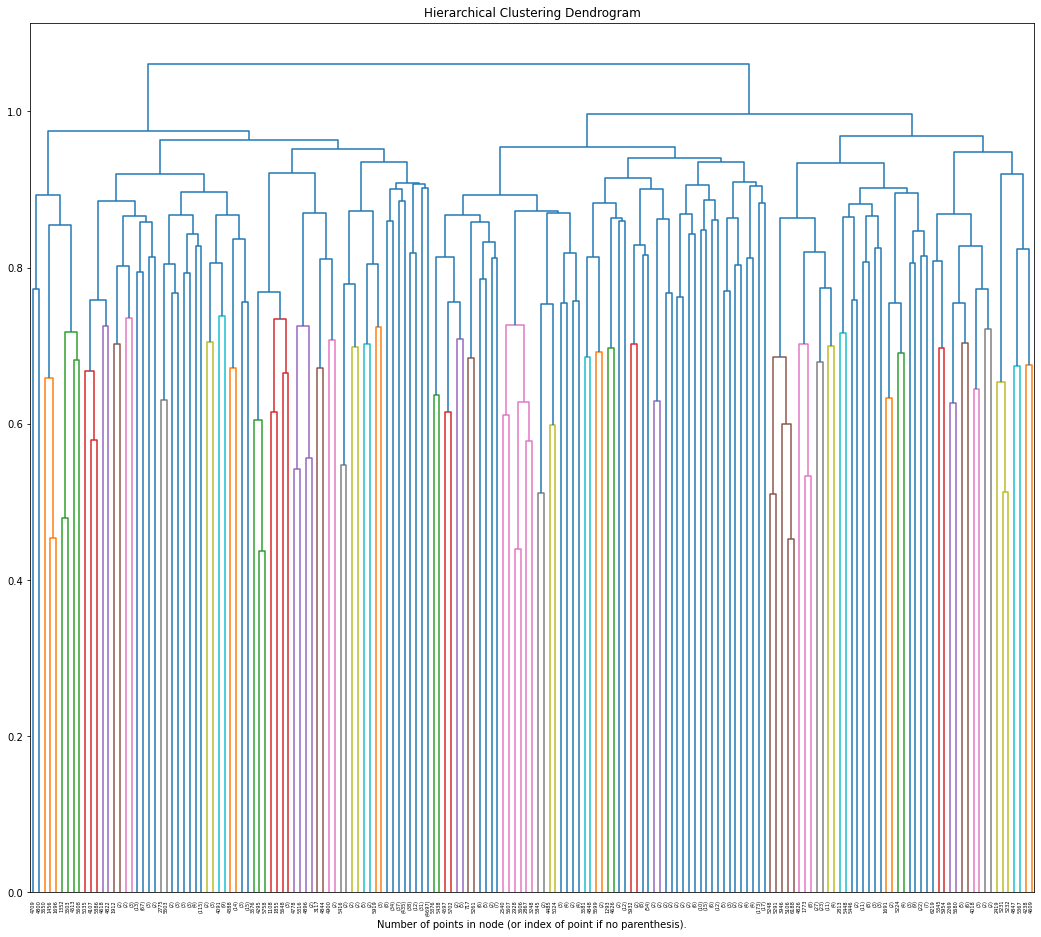

In [20]:
# Plot Dendrogram
# This cell only functions if n_clusters is not specified in the agglomerative clustering

plot_dendrogram(clustering_agg_words, truncate_mode="level", p=7)

In [21]:
# K-Means Clustering

num_clusters_words = 50
# L2 normalising the embeddings makes K-means euclidean clustering the same as K-means cosine similarity clustering
kmeans_words = KMeans(n_clusters=num_clusters_words-1, random_state=0, n_init=10).fit(normalize(embedding_matrix_nz, axis=1))
for i in range(len(valid_word_index)):
    # We reserve zero for words that don't belong to the GloVe model.
    freq_analysis_df.iloc[valid_word_index[i],2] = kmeans_words.labels_[i]+1

In [22]:
# Display Cluster Information

for k in range(num_clusters_words):
  print("\nCluster: ",k)
  cluster_df = freq_analysis_df[freq_analysis_df["Cluster"]==k]
  print(len(cluster_df)/len(freq_analysis_df))
  print("Average Word Count: ", np.mean(cluster_df["Count"]))
  print(freq_analysis_df[freq_analysis_df["Cluster"]==k].iloc[:30])


Cluster:  0
0.3497753161249869
Average Word Count:  3.3334329250074695
                   Word  Count  Cluster
51               #cop25   2208        0
174      #climateaction    391        0
446      #timeforaction    316        0
111      #climatechange    262        0
210      @gretathunberg    220        0
1374       #cop25madrid    194        0
847         #stepup2020    138        0
424   #climateemergency    133        0
17                cop25    121        0
686            #climate    109        0
191                 @un     92        0
60      #parisagreement     86        0
1635     #climatestrike     77        0
404             @unfccc     76        0
1517              #ipcc     75        0
856               #ndcs     69        0
1851   @antonioguterres     66        0
230   #fridaysforfuture     65        0
311             #auspol     62        0
45             #netzero     59        0
1019     #climatecrisis     52        0
5561     @climatemorgan     50        0
940     

In [23]:
# More detail about a specific cluster

freq_analysis_df[freq_analysis_df["Cluster"]==26].head(50)

,Word,Count,Cluster
1932,rights,61,26
229,act,60,26
439,civil,45,26
620,government,41,26
2386,justice,40,26
795,delegates,36,26
1939,state,26,26
579,presidency,25,26
702,issue,25,26
2210,panel,25,26


### PCA Visualisation of Lexicon Clusters

In [24]:
# Compute first three principal components of word embedding data

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
embedding_matrix_pc = pca.fit_transform(embedding_matrix)
freq_analysis_df["PC1"] = embedding_matrix_pc[:,0]
freq_analysis_df["PC2"] = embedding_matrix_pc[:,1]
freq_analysis_df["PC3"] = embedding_matrix_pc[:,2]

In [25]:
pca.explained_variance_ratio_

array([0.13741926, 0.04365474, 0.03707017])

In [26]:
# Filter dataframe for plotting

freq_analysis_df_filtered = freq_analysis_df[freq_analysis_df["Cluster"].isin([2,3,20,36,45]) & (freq_analysis_df["Count"]>0)]

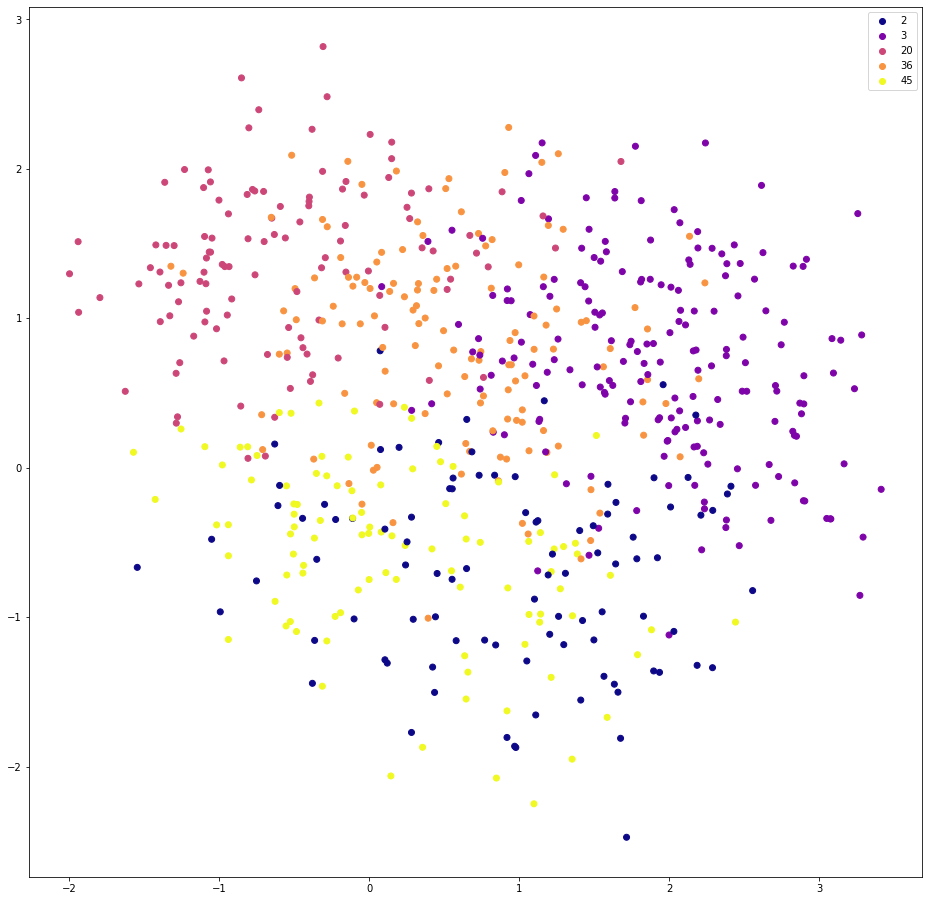

In [27]:
# 2D PC Plot

colours_unique, colours_scaled = scatter_cmap(list(freq_analysis_df_filtered["Cluster"]))

plt.figure(figsize=(16,16))
scatter = plt.scatter(freq_analysis_df_filtered["PC1"],
            freq_analysis_df_filtered["PC2"],
            c=colours_scaled,
            cmap = "plasma")
handles, labels = scatter.legend_elements()
plt.legend(handles, colours_unique)
plt.show()

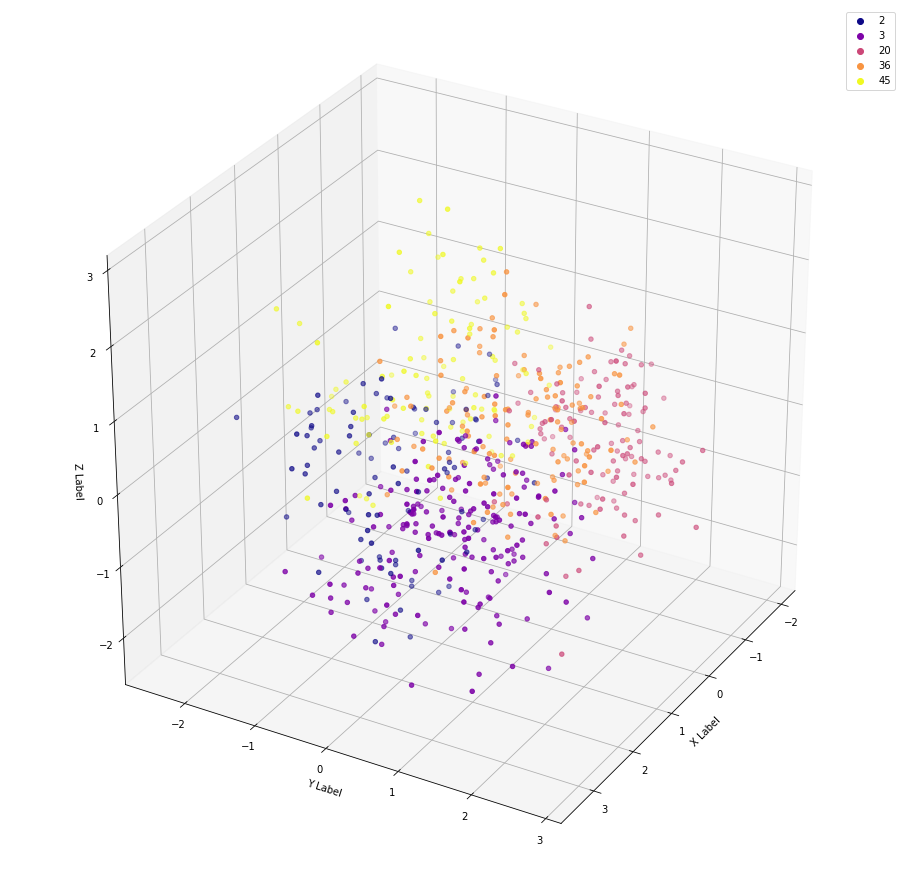

In [28]:
# 3D PC Plot

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(projection='3d')

colours_unique, colours_scaled = scatter_cmap(list(freq_analysis_df_filtered["Cluster"]))

scatter = ax.scatter(freq_analysis_df_filtered["PC1"],
           freq_analysis_df_filtered["PC2"],
           freq_analysis_df_filtered["PC3"],
           c=colours_scaled,
          cmap = "plasma")

handles, labels = scatter.legend_elements()
plt.legend(handles, colours_unique)

ax.view_init(30, 30)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

## Tweet-Level Analysis

### Average Embedding Vector Clustering

In [29]:
# Create an average embedding vector for each tweet
# Ignore stop words

tweet_sequences = tokenizer.texts_to_sequences(tweets_clean)
stop_words_tokens = tokenizer.texts_to_sequences([stop_words])[0]

tweet_embedding_avg_matrix = np.zeros((len(tweets_df), 100))
for i in range(len(tweets_df)):
    vector_sum = np.zeros(100)
    for token in tweet_sequences[i]:
        vector_sum += embedding_matrix[token - 2]
    tweet_embedding_avg_matrix[i] = vector_sum
tweet_embedding_avg_matrix = normalize(tweet_embedding_avg_matrix, axis=1)
tweets_df = pd.concat([tweets_df,
                                 pd.DataFrame(data=tweet_embedding_avg_matrix, columns=["ec"+str(i) for i in range(100)])],
                                 axis=1)

In [30]:
# Average embedding vector clustering (agglomerative)

num_clusters_tweets = 8
clustering_agg_tweets_avg = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1,
                                                    linkage="complete", affinity="cosine").fit(tweet_embedding_avg_matrix)

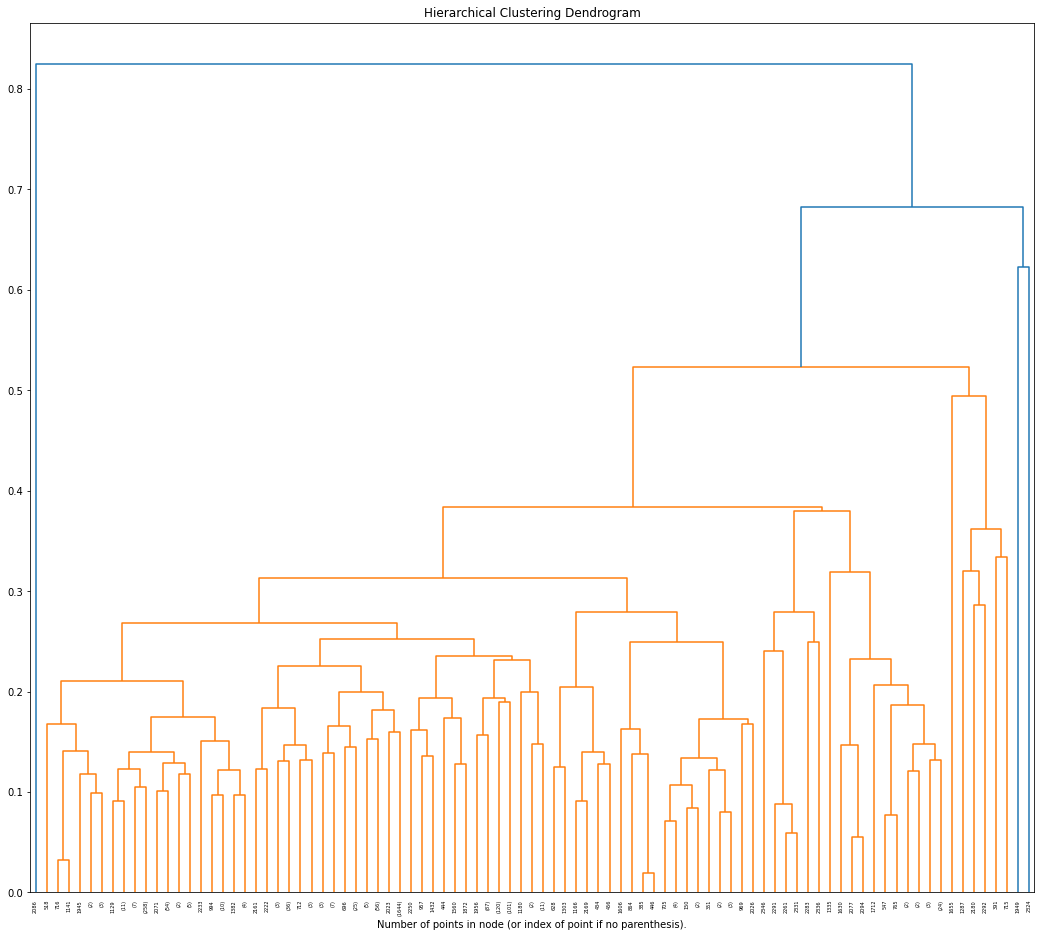

In [31]:
plot_dendrogram(clustering_agg_tweets_avg, truncate_mode="level", p=10)

In [32]:
# Average embedding vector clustering (kmeans)

num_clusters_tweets = 8
kmeans_tweets_avg = KMeans(n_clusters=num_clusters_tweets, random_state=0, n_init=10).fit(tweet_embedding_avg_matrix)
tweets_df["Cluster"] = kmeans_tweets_avg.labels_

### Cluster Exploration

In [33]:
# Display information about each cluster

for k in range(num_clusters_tweets):
    print("\nCluster: ",k)
    cluster_df = tweets_df[tweets_df["Cluster"]==k]
    print("Fraction of Data: ", len(cluster_df)/len(tweets_df))
    print("Average Likes: ", np.mean(cluster_df["Likes"]))
    for i in range(3):
        if i< len(cluster_df):
            print(cluster_df.sort_values(by="Likes", ascending=False).iloc[i,9])


Cluster:  0
Fraction of Data:  0.080859375
Average Likes:  338.32850241545896
Pioneers in #renewables, with an investment of &gt;100,000 million €... and we continue leading the energy transition. Clean energy is essential in the fight against #climatechange! ♻️💚🌍#COP25 #TimeToAct 
https://t.co/JBfXS4koqm https://t.co/YETz9xxsUq
It seems the #COP25 made the most shameful kind of history today: Shortly after welcoming @GretaThunberg to speak, more than 100 climate activists got forcefully thrown out after a peaceful protest. That has never happened before, it’s outrageous.
The people won’t be silenced. 💥 https://t.co/UuztFmPqkp
🌎 

NATO Review just published my article:

Planetary Security, the security implications of climate change. 

RTs appreciated 😊

➡️ https://t.co/v5f6QmPf8X

#COP25 #ClimateEmergency #ClimateChange #security #conflict #AI #peace #SDGs @GretaThunberg #ActOnClimate #ClimateAction https://t.co/fntQUKymlf

Cluster:  1
Fraction of Data:  0.1078125
Average Likes:  186

In [47]:
# Tweets from a specific cluster

list(tweets_df[tweets_df["Cluster"]==2].sort_values(by="Likes", ascending=False)["Content"].iloc[:50])

['"I’m not traveling like this because I want everyone to do so, I’m doing this to send a message that it is impossible to live sustainably today &amp; that needs to change. It needs to become much easier."\n\nGreat messaging by @GretaThunberg as usual! \n#COP25\n\nhttps://t.co/nysN9UyM7u',
 'It seems like #cop25 in Madrid is falling apart right now. The science is clear, but the science is being ignored.\nWhatever happens we will never give up. We have only just begun. https://t.co/wEFIDLU382',
 'I am super excited to meet my inspiration and role model @GretaThunberg. #COP25 #FridaysForFuture https://t.co/VpiFTHFbei',
 'I made it to COP25\n\nAnd Oh My God!!! \n\n@GretaThunberg https://t.co/qCK354GiEh',
 'To address the climate emergency, we need a rapid &amp; deep change in how we do business, how we generate power, how we build cities, how we move and how we feed the world.\n\nIf we don’t urgently change our way of life, we jeopardize life itself. #COP25 https://t.co/S5eRCCXoEa',
 'A

In [35]:
# Group tweets_df by category and cluster

tweets_cat_clust_df = pd.DataFrame(tweets_df["Date"].unique())
tweets_cat_clust_df = tweets_cat_clust_df.merge(pd.DataFrame(tweets_df["Category"].unique()), how="cross")
tweets_cat_clust_df = tweets_cat_clust_df.merge(pd.DataFrame(tweets_df["Cluster"].unique()), how="cross")
tweets_cat_clust_df = pd.DataFrame(np.array(tweets_cat_clust_df),
                                   columns = ["Date", "Category", "Cluster"])
tweets_cat_clust_df = tweets_cat_clust_df.merge(tweets_df.groupby(["Date", "Category", "Cluster"]).count().rename(columns={"ID":"Count"})["Count"],
                                                how="left", on=["Date", "Category", "Cluster"])
tweets_cat_clust_df = tweets_cat_clust_df.merge(tweets_df.groupby(["Date", "Category", "Cluster"]).sum()["Likes"],
                                                how="left", on=["Date", "Category", "Cluster"])
tweets_cat_clust_df.fillna(0,inplace=True)
tweets_cat_clust_df.sort_values(by = ["Date", "Category", "Cluster"], inplace=True)
tweets_cat_clust_df.reset_index(inplace=True)
tweets_cat_clust_df

,index,Date,Category,Cluster,Count,Likes
0,0,2019-11-15,Activist,0,1.0,766.0
1,1,2019-11-15,Activist,1,1.0,19.0
2,4,2019-11-15,Activist,2,2.0,79.0
3,6,2019-11-15,Activist,3,0.0,0.0
4,5,2019-11-15,Activist,4,0.0,0.0
...,...,...,...,...,...,...
2947,2942,2019-12-27,Scientist,3,0.0,0.0
2948,2941,2019-12-27,Scientist,4,0.0,0.0
2949,2938,2019-12-27,Scientist,5,0.0,0.0
2950,2939,2019-12-27,Scientist,6,0.0,0.0


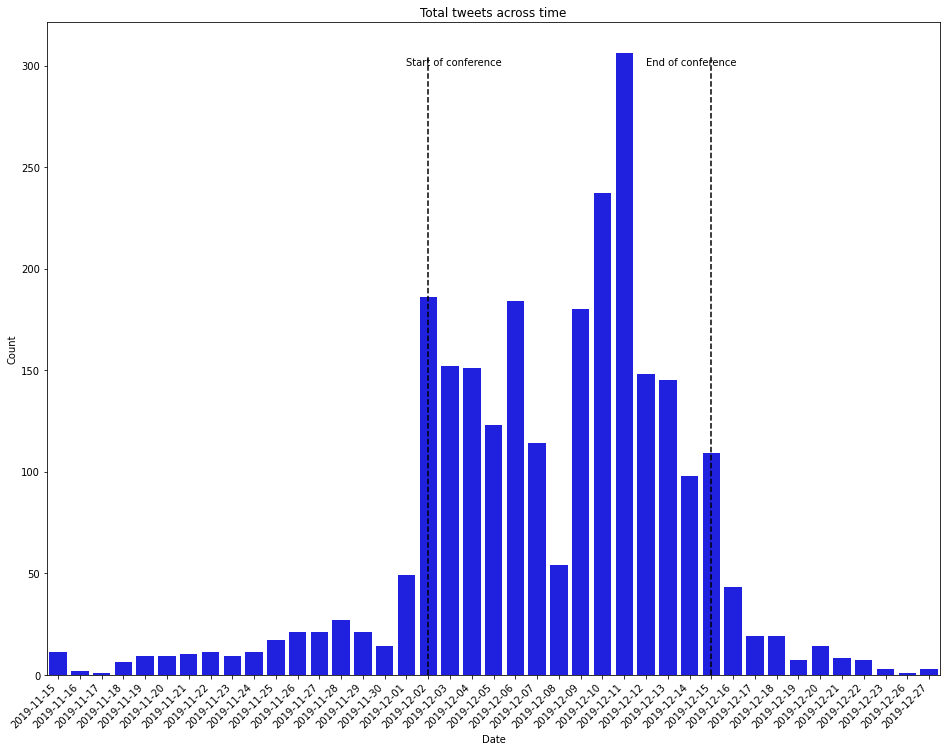

In [36]:
# Total tweet counts time series

plt.figure(figsize=(16,12))
bar = sns.barplot(data=tweets_cat_clust_df.groupby(["Date"]).sum().reset_index(), x="Date", y="Count", color="blue", ci=None)
bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Total tweets across time")
plt.axvline(17, 0, 0.95 , color="black", linestyle="--")
plt.axvline(30, 0, 0.95 , color="black", linestyle="--")
plt.text(16, 300, "Start of conference")
plt.text(27, 300, "End of conference")
plt.show()

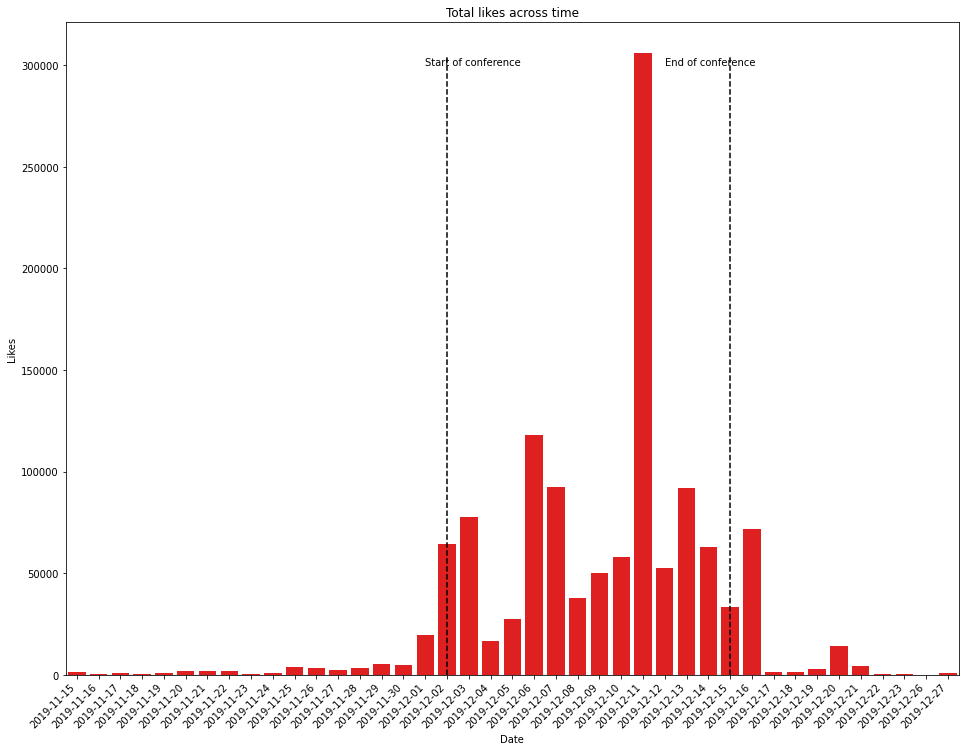

In [37]:
# Total tweet likes time series

plt.figure(figsize=(16,12))
bar = sns.barplot(data=tweets_cat_clust_df.groupby(["Date"]).sum().reset_index(), x="Date", y="Likes", color="red", ci=None, )
bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Total likes across time")
plt.axvline(17, 0, 0.95 , color="black", linestyle="--")
plt.axvline(30, 0, 0.95 , color="black", linestyle="--")
plt.text(16, 300000, "Start of conference")
plt.text(27, 300000, "End of conference")
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1296x1152 with 0 Axes>

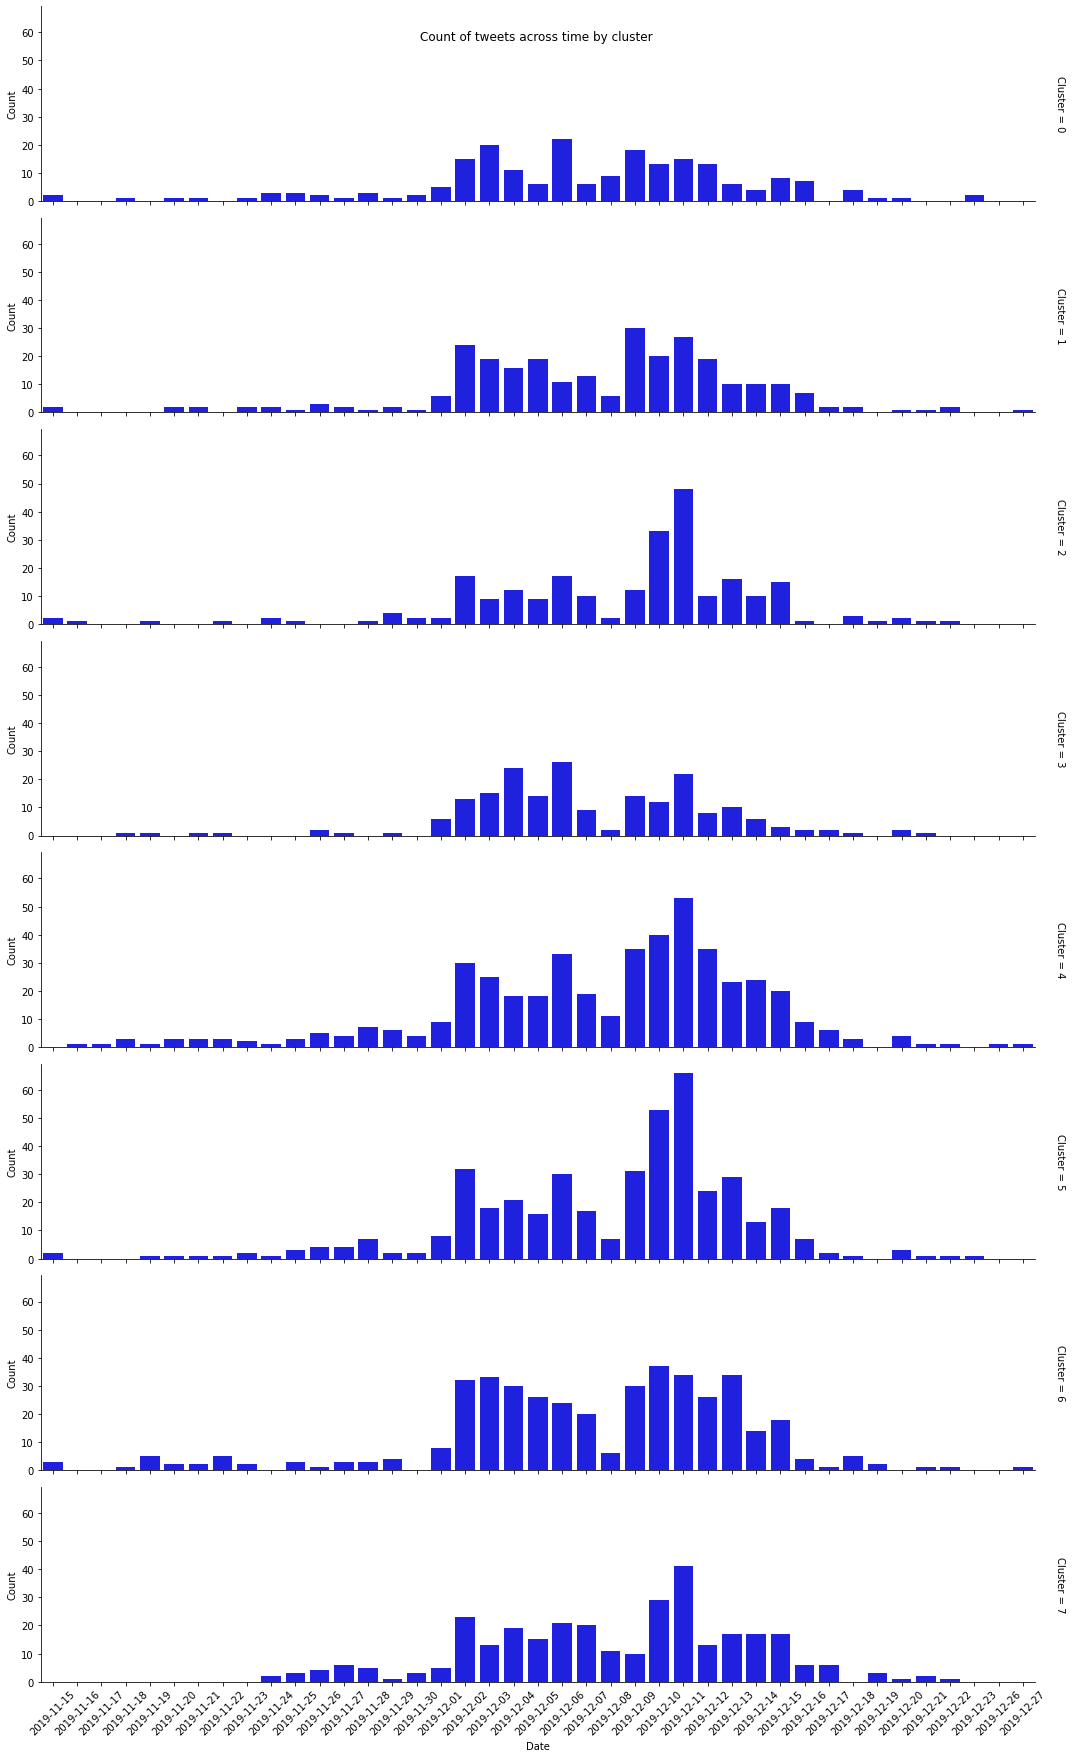

In [38]:
# Count of Tweets Across Time by Cluster

plt.figure(figsize=(18,16))
g = sns.FacetGrid(tweets_cat_clust_df.groupby(["Date","Cluster"]).sum().reset_index(),
                  row="Cluster", aspect=5, margin_titles=True, sharey=True)
g.map(sns.barplot, "Date", "Count", ci=None, color="blue")
g.fig.suptitle("Count of tweets across time by cluster")
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1296x1152 with 0 Axes>

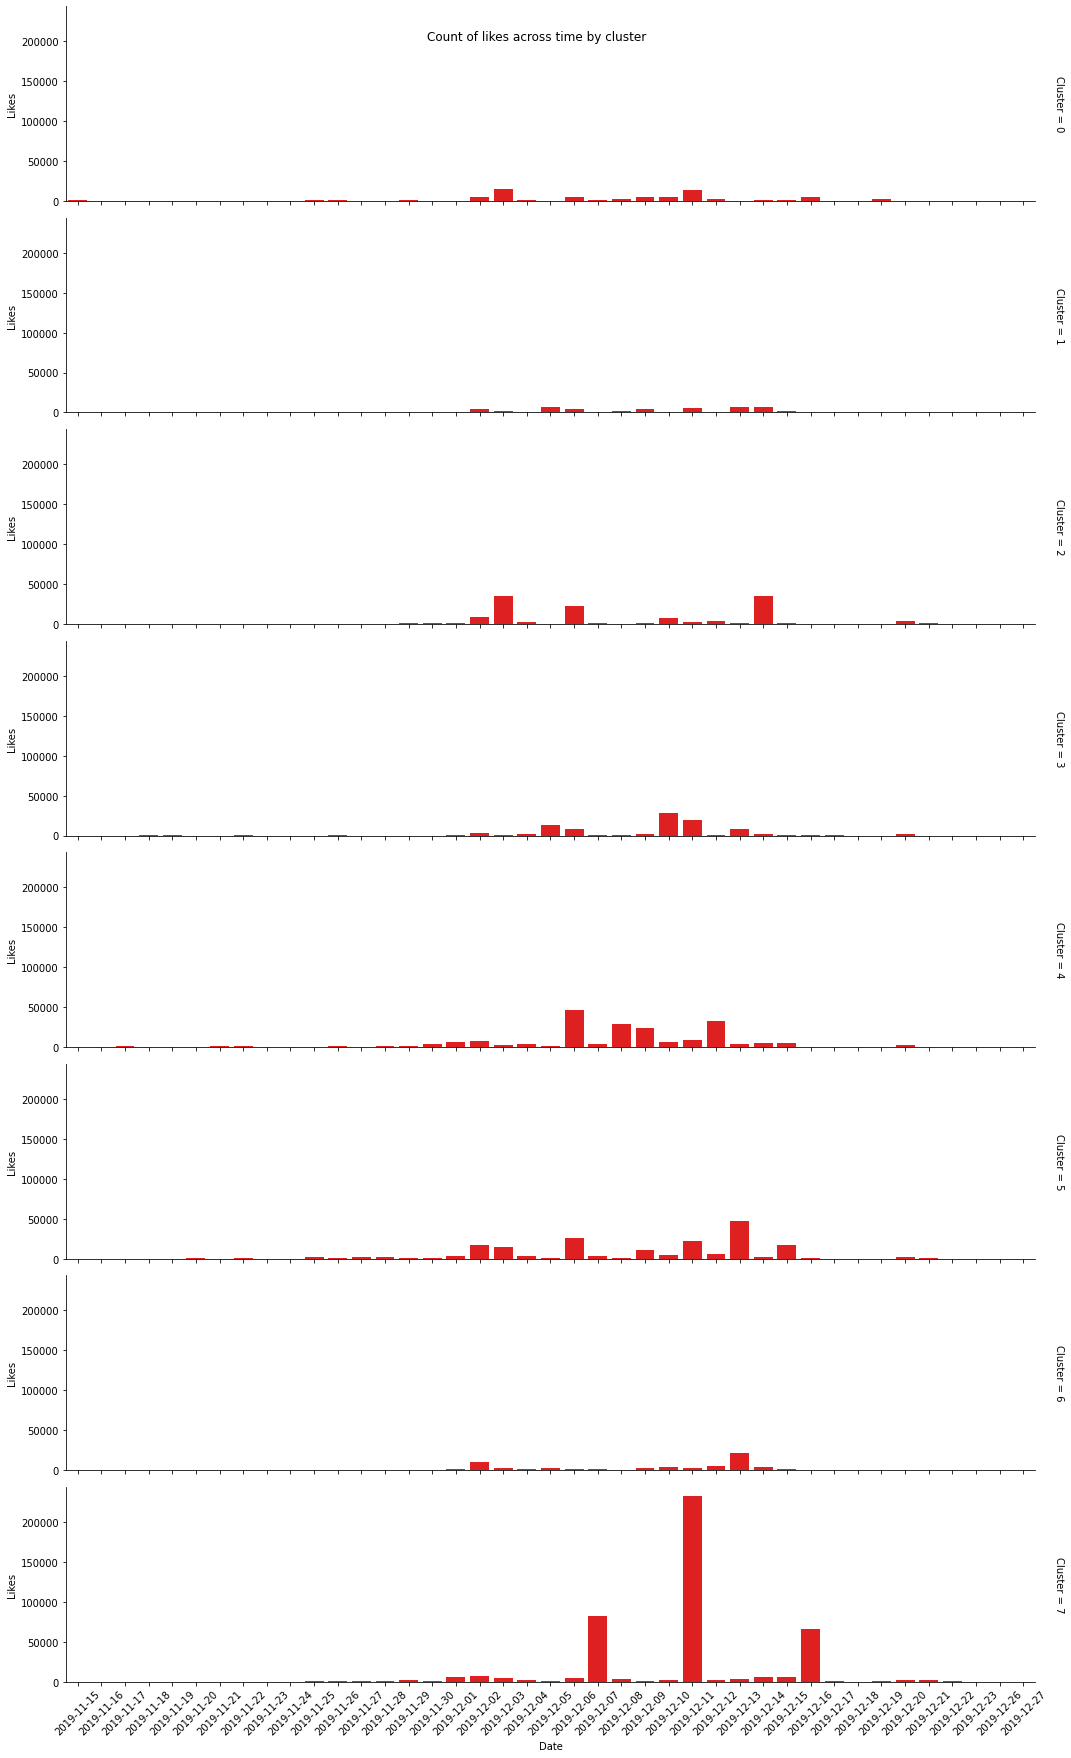

In [39]:
# Tweet Likes Across Time by Cluster

plt.figure(figsize=(18,16))
g = sns.FacetGrid(tweets_cat_clust_df.groupby(["Date","Cluster"]).sum().reset_index(),
                  row="Cluster", aspect=5, margin_titles=True, sharey=True)
g.map(sns.barplot, "Date", "Likes", ci=None, color="red")
g.fig.suptitle("Count of likes across time by cluster")
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1296x1152 with 0 Axes>

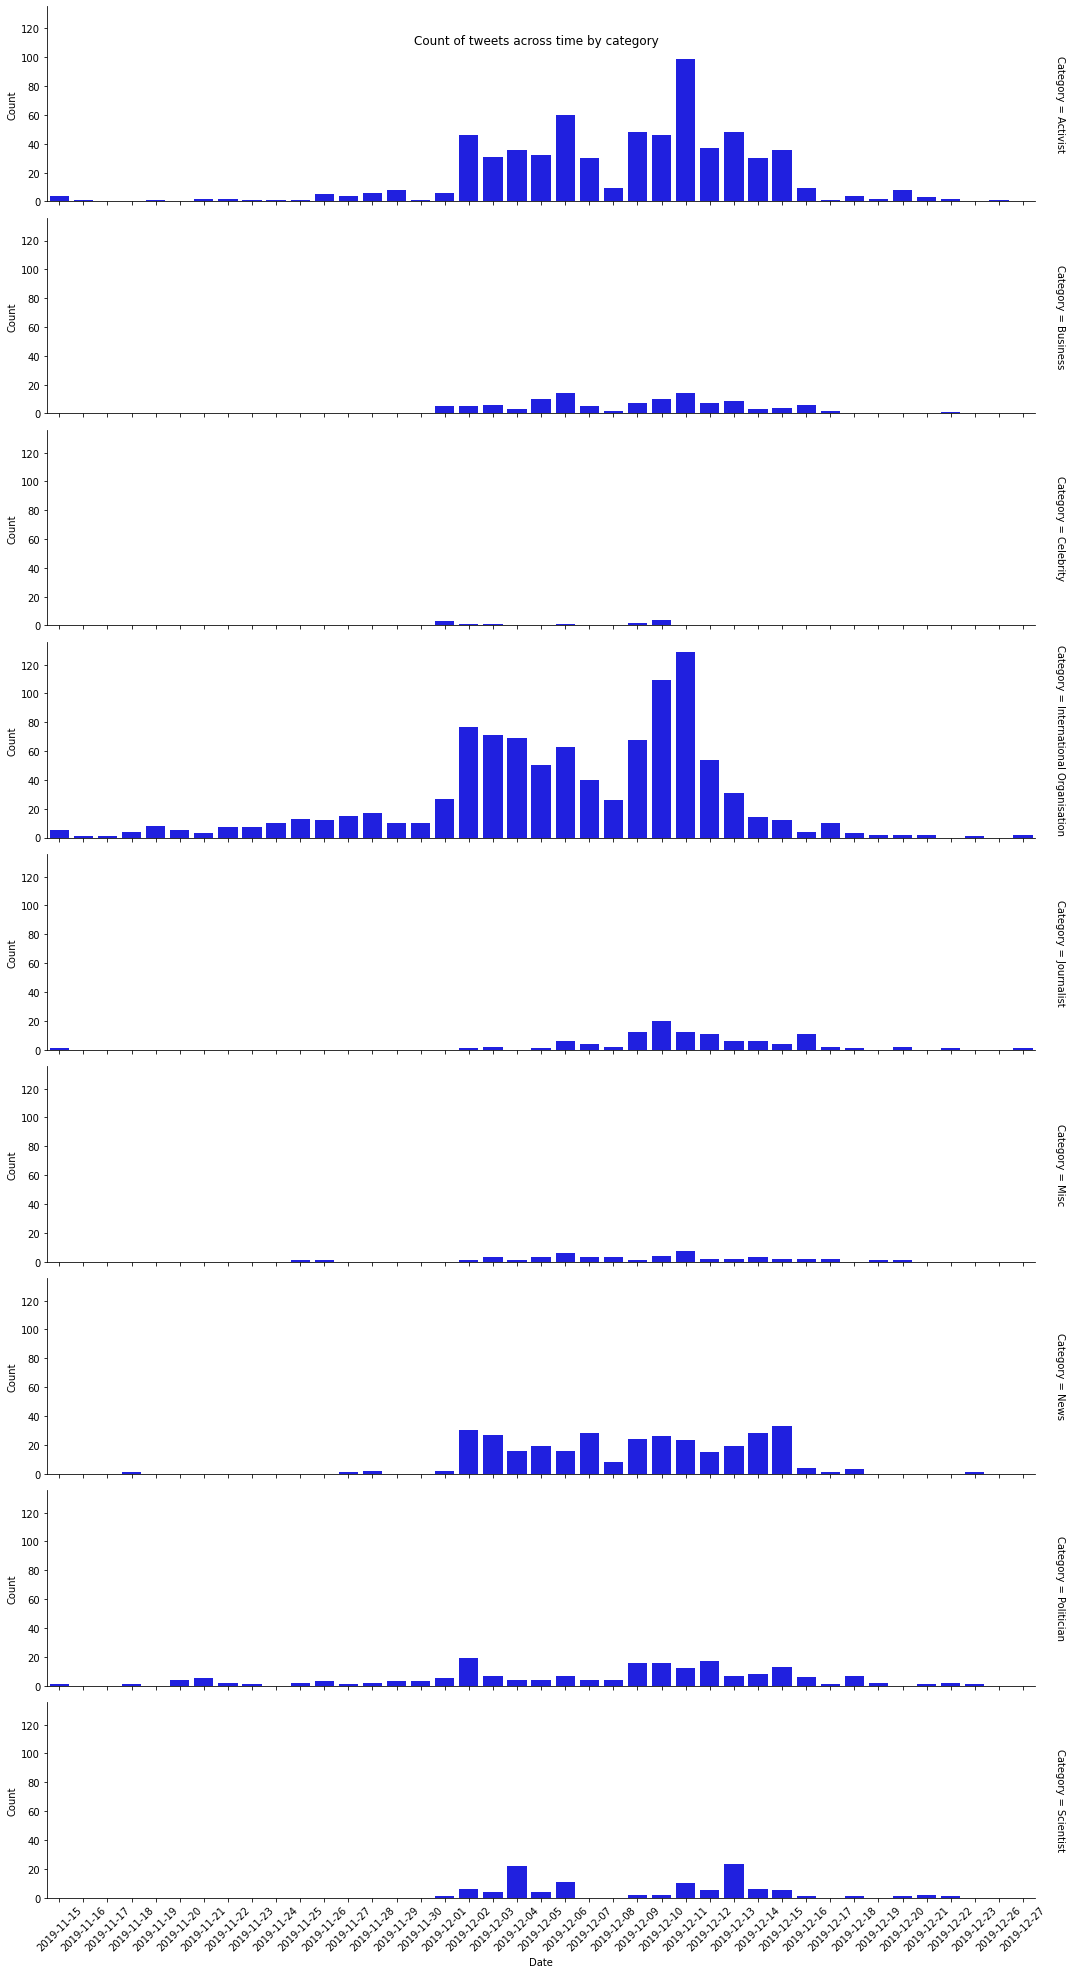

In [40]:
# Tweet Counts Across Time by Category

plt.figure(figsize=(18,16))
g = sns.FacetGrid(tweets_cat_clust_df.groupby(["Date","Category"]).sum().reset_index(), row="Category", aspect=5, margin_titles=True, sharey=True)
g.map(sns.barplot, "Date", "Count", ci=None, color="blue")
g.fig.suptitle("Count of tweets across time by category")
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1296x1152 with 0 Axes>

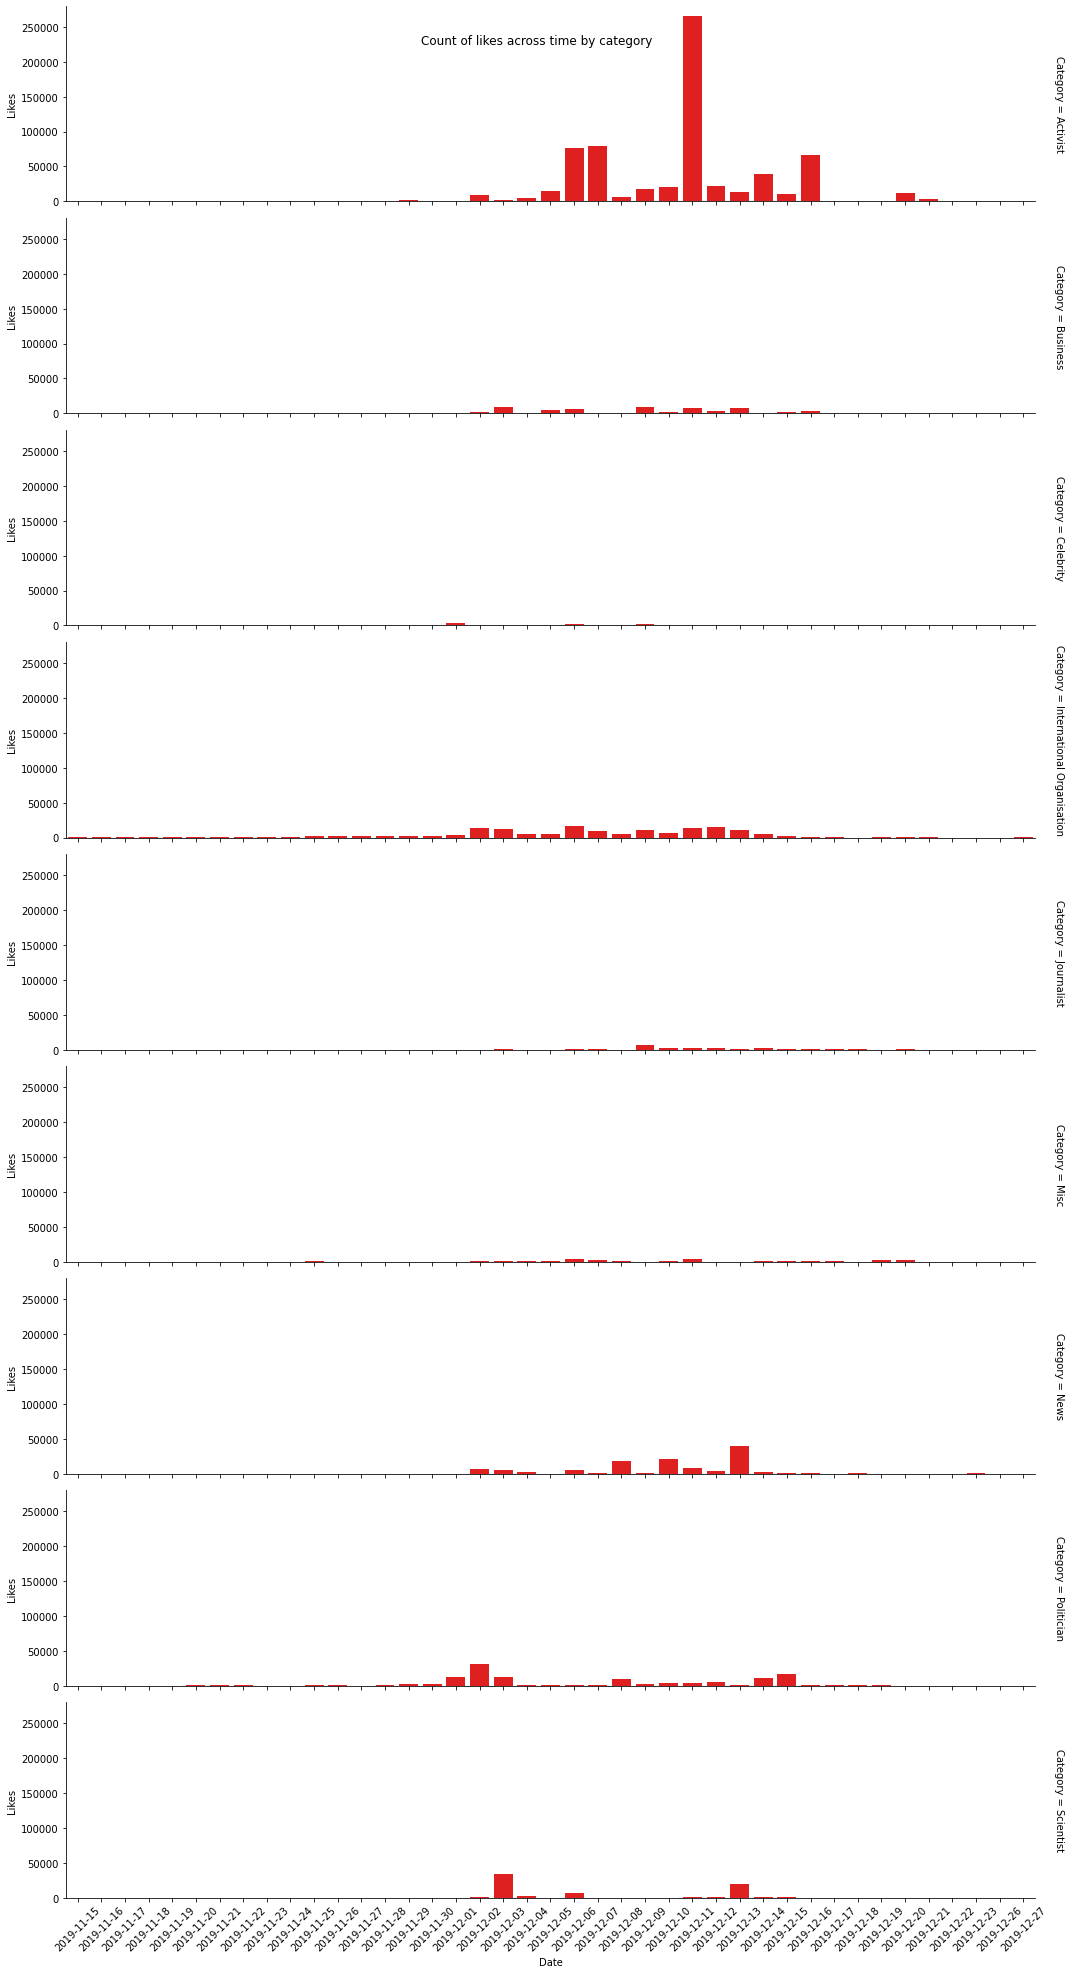

In [41]:
# Tweet Likes Across Time by Category

plt.figure(figsize=(18,16))
g = sns.FacetGrid(tweets_cat_clust_df.groupby(["Date","Category"]).sum().reset_index(), row="Category", aspect=5, margin_titles=True, sharey=True)
g.map(sns.barplot, "Date", "Likes", ci=None, color="red")
g.fig.suptitle("Count of likes across time by category")
plt.xticks(rotation=45)
plt.show()

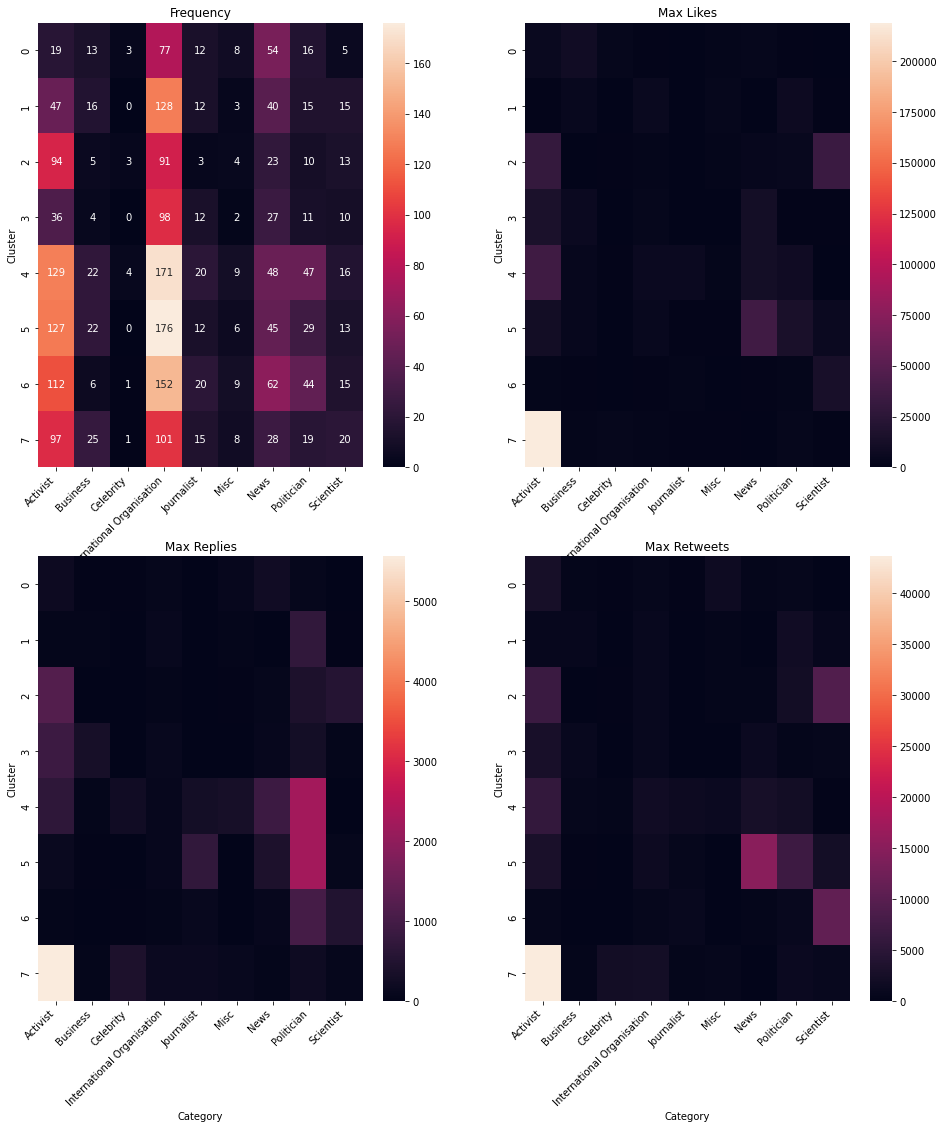

In [42]:
# Cluster-Category co-occurence matrices

plt.figure(figsize=(16,18))

plt.subplot(221)
plt.title("Frequency")
heat = sns.heatmap(tweets_df.pivot_table(values="ID",index="Cluster",columns="Category",aggfunc="count").fillna(0.0), annot=True, fmt="g")
heat.set_xticklabels(heat.get_xticklabels(), rotation=45, horizontalalignment='right')

for i, val in enumerate(["Likes","Replies","Retweets"]):
    plt.subplot(222+i)
    plt.title("Max "+val)
    heat = sns.heatmap(tweets_df.pivot_table(values=val,index="Cluster",columns="Category",aggfunc="max").fillna(0.0))
    heat.set_xticklabels(heat.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

<Figure size 1296x1152 with 0 Axes>

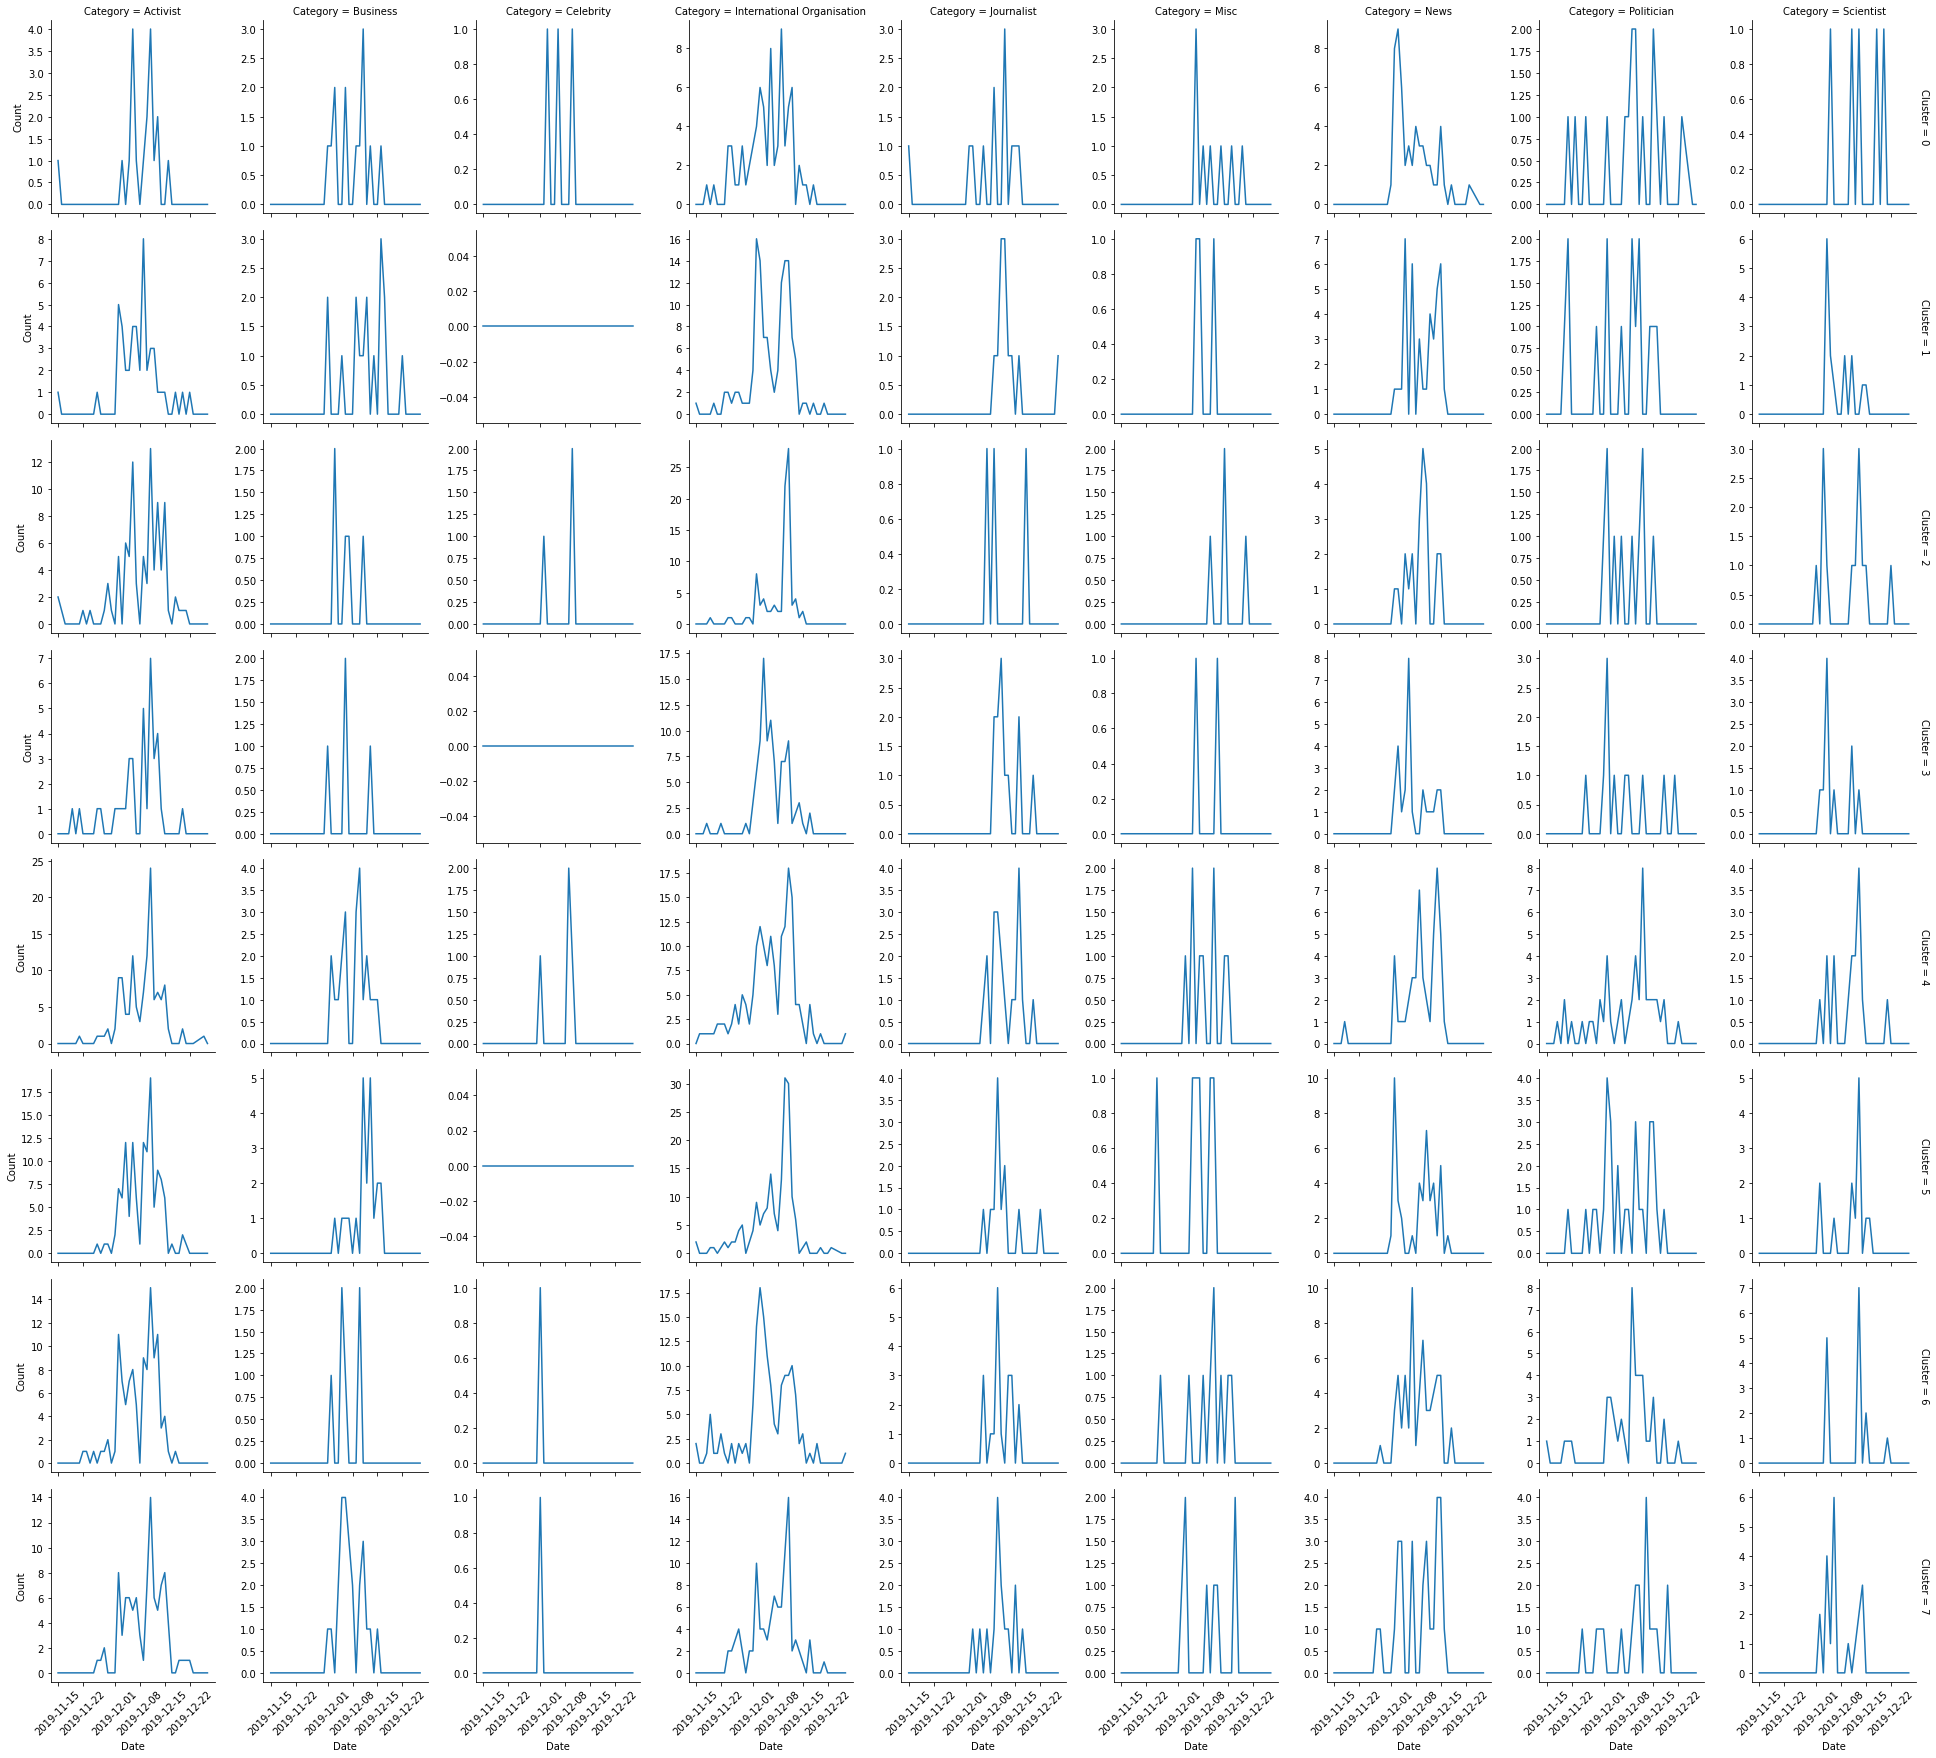

In [43]:
# Timeseries of Counts of Tweets by Cluster and Category

plt.figure(figsize=(18,16))
g = sns.FacetGrid(tweets_cat_clust_df, row = "Cluster", col="Category", margin_titles=True, sharey=False)
g.map(sns.lineplot, "Date", "Count", err_style=None)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.show()

In [44]:
# PCA

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
tweet_embedding_avg_matrix_pc = pca.fit_transform(tweet_embedding_avg_matrix)
tweets_df["PC1"] = tweet_embedding_avg_matrix_pc[:,0]
tweets_df["PC2"] = tweet_embedding_avg_matrix_pc[:,1]
tweets_df["PC3"] = tweet_embedding_avg_matrix_pc[:,2]

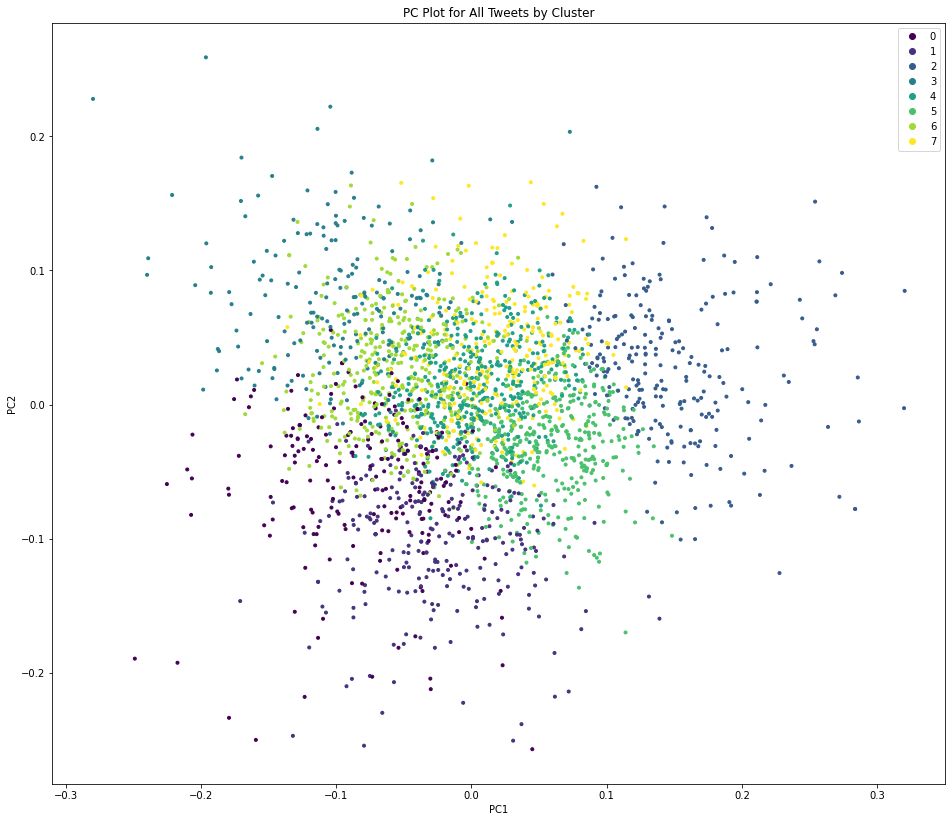

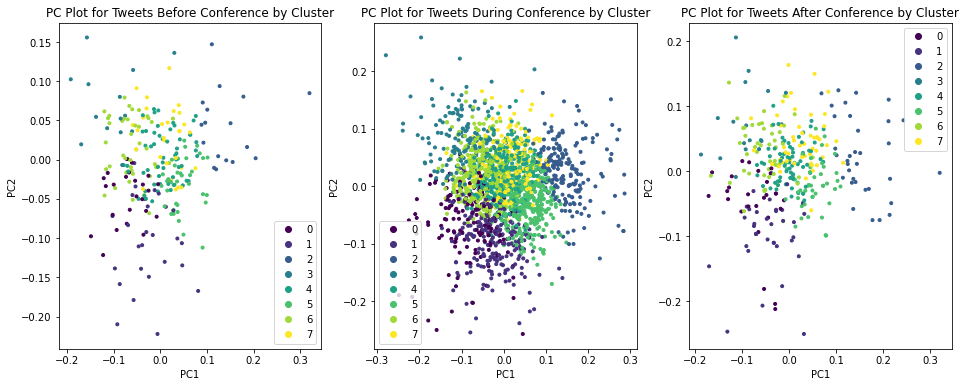

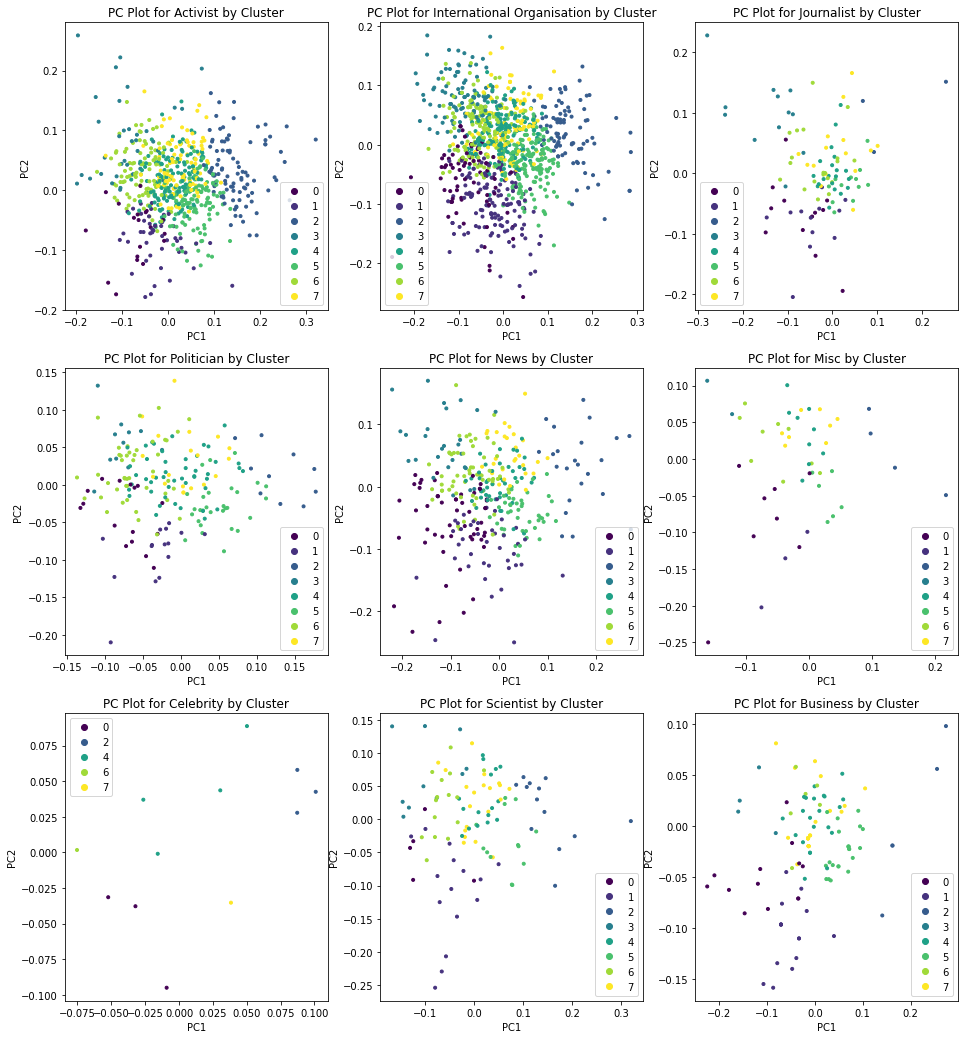

In [45]:
# PC Plots

# Organise colours
colours_unique_all, colours_scaled_all = scatter_cmap(list(tweets_df["Cluster"]))
tweets_df["colours_scaled"] = colours_scaled_all
tweets_df["period"] = tweets_df["Date"].apply(lambda x: (x >= dt.datetime.strptime("2019-12-02","%Y-%m-%d").date()) + (x > dt.datetime.strptime("2019-12-13","%Y-%m-%d").date()))

# All-time plot

plt.figure(figsize=(16,14))

scatter = plt.scatter(tweets_df["PC1"],
                      tweets_df["PC2"],
                      c=colours_scaled_all,
                      cmap = "viridis",
                      marker='.')
handles, labels = scatter.legend_elements()
plt.legend(handles, colours_unique_all)
plt.title("PC Plot for All Tweets by Cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

# Plots for each period

plt.figure(figsize=(16,6))

for i, p in enumerate(["Before","During","After"]):
    plt.subplot(131+i)
    tweets_df_filtered = tweets_df[tweets_df["period"] == i]
    colours_scaled = list(tweets_df_filtered["colours_scaled"])
    colours_unique = list(set(list(tweets_df_filtered["Cluster"])))
    scatter = plt.scatter(tweets_df_filtered["PC1"],
                tweets_df_filtered["PC2"],
                c=colours_scaled,
                cmap = "viridis",
                marker='.')
    handles, labels = scatter.legend_elements()
    plt.legend(handles, colours_unique)
    plt.title("PC Plot for Tweets "+p+" Conference by Cluster")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

plt.show()

# Plots for each category

categories = list(tweets_df["Category"].unique())

plt.figure(figsize=(16,18))

for i, cat in enumerate(categories):
    plt.subplot(331+i)
    tweets_df_filtered = tweets_df[tweets_df["Category"] == cat]
    colours_scaled = list(tweets_df_filtered["colours_scaled"])
    colours_unique = list(set(list(tweets_df_filtered["Cluster"])))
    scatter = plt.scatter(tweets_df_filtered["PC1"],
                tweets_df_filtered["PC2"],
                c=colours_scaled,
                cmap = "viridis",
                marker='.')
    handles, labels = scatter.legend_elements()
    plt.legend(handles, colours_unique)
    plt.title("PC Plot for "+cat+" by Cluster")
    plt.xlabel("PC1")
    plt.ylabel("PC2")